In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from src.models import *

# you might need to install tqdm if not already installed 
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Pytorch dataset for CNN model
class CustomTensorDataset(Dataset):
    def __init__(self, dataset, transform_list=None):
        self.tensors = dataset
        self.data_len = len(dataset[0])

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        return x, y
    
    def __len__(self):
        return self.data_len

In [5]:
# data cleaning 
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

def parse_time(X):
    dt = X['TIMESTAMP'].apply(datetime.fromtimestamp)
    X['YR'] = dt.dt.year
    X['MON'] = dt.dt.month
    X['DAY'] = dt.dt.day
    X['HR'] = dt.dt.hour
    X['WK'] = dt.dt.weekday
    return X

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)


# Define the columns to include in the ColumnTransformer
columns_to_include = ['CALL_TYPE', 'TAXI_ID', 'ORIGIN_STAND']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('impute', SimpleImputer(strategy='most_frequent'), ['ORIGIN_STAND']),
        ('ohe', OneHotEncoder(), columns_to_include),
    ])



pipeline = Pipeline(steps=[
    ('column_dropper', ColumnDropper(columns=['TRIP_ID', 'ORIGIN_CALL', 'DAY_TYPE', 'MISSING_DATA'])),
    ('time_transformer', FunctionTransformer(parse_time, validate=False)),
    ('preprocessor', preprocessor)
])


In [6]:
#Load Data, it might take some time before fully read in and finish the process

df_tr = pd.read_csv("data/train.csv")
X = df_tr.drop('POLYLINE', axis=1)
y = df_tr['POLYLINE'].apply(polyline_to_trip_duration)

X = pipeline.fit_transform(X)
y = y.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

X_train = torch.FloatTensor(X_train.todense()).to(device)
X_val = torch.FloatTensor(X_val.todense()).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_val = torch.FloatTensor(y_val).to(device)

/home/zhishang/anaconda3/lib/python3.8/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [9]:
#Model MLP
# if load the saved models
load = True
# 0 is mlp with simpler architecture and 1 is mlp with more complicated architecture
mlp = 0

if not load:
    if mlp == 0:
        model = MLP_1(516, 64, 1).to(device)
    else:
        model = MLP_2(516, 64, 1).to(device)
else:
    if mlp == 0:
        model = torch.load("saved_model_mlp1.pt")
    else:
        model = torch.load("saved_model_mlp2.pt")
        
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model

MLP_1(
  (fc1): Linear(in_features=516, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
# Training Process with 1000 epochs

epochs = 1000

loss_tr_lst = []
loss_te_lst = []

for i_epoch in range(1, epochs+1):
    
    model.train()
    
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(torch.squeeze(output), y_train)
    loss_tr_lst.append(loss.item())
    loss.backward()
    optimizer.step()
    
    
    model.eval()
    
    output_val = model(X_val)
    loss_val = loss_fn(torch.squeeze(output_val), y_val)
    loss_te_lst.append(loss_val.item())
    
    if i_epoch % 100 == 0 and i_epoch >= 100:
        print(i_epoch, loss_tr_lst[-1], loss_te_lst[-1])

100 449684.46875 437991.78125
200 446694.8125 435005.0
300 443492.78125 431295.71875
400 440726.6875 428793.3125
500 438903.34375 426621.125
600 437553.34375 425707.15625
700 436559.3125 424242.96875
800 436071.21875 423185.28125
900 435687.6875 422581.28125
1000 435233.875 421801.34375


Text(0, 0.5, 'SE')

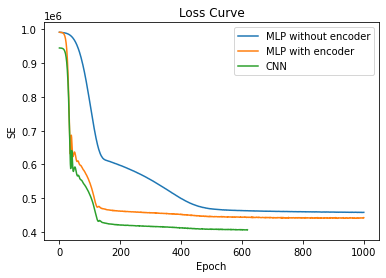

In [19]:
# visualization

# plt.plot([idx for idx in range(len(loss_tr_mlp1_lst))], loss_tr_mlp1_lst)
# plt.plot([idx for idx in range(len(loss_tr_mlp2_lst))], loss_tr_mlp2_lst)
# plt.plot([idx for idx in range(len(loss_te))], loss_te)
# plt.legend(["MLP without encoder", "MLP with encoder", "CNN"])
# plt.title("Loss Curve")
# plt.xlabel("Epoch")
# plt.ylabel("SE")

In [7]:
# CNN part
X_train, X_val = X_train.reshape(-1, 1, 516), X_val.reshape(-1, 1, 516)
dataset = CustomTensorDataset((X_train, y_train))
dataset_val = CustomTensorDataset((X_val, y_val))

In [8]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=500)
valloader = torch.utils.data.DataLoader(dataset_val, batch_size=500)

In [9]:
model = CNN().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

test


In [11]:
# start training
epochs = 100

loss_tr_lst = []
loss_te_lst = []

for i_epoch in range(1, epochs+1):
    
    model.train()
    sum_loss_tr = 0
    sum_loss_te = 0
    
    for x, y in trainloader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(torch.squeeze(output), y)
        sum_loss_tr += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_tr_lst.append(sum_loss_tr/len(trainloader))
    
    model.eval()
    
    for x, y in valloader:
        output_val = model(x)
        loss_val = loss_fn(torch.squeeze(output_val), y)
        sum_loss_te += loss_val.item()
    
    loss_te_lst.append(sum_loss_te/len(valloader))
    
    print(i_epoch, loss_tr_lst[-1], loss_te_lst[-1])

1 472499.52728794643 484188.23669825075
2 459708.18397930195 479164.9409620991
3 455066.9598569399 475538.65415451897
4 451761.9627232143 473912.50993075804
5 449814.9791548295 471355.05707908166
6 446495.21732700896 467497.71396683675
7 443132.68243709416 466608.76134293
8 440880.9617212865 465896.6082817055
9 439451.20082437096 464902.25081997085
10 438329.7921291599 463862.9410076531
11 437078.03787286935 462416.61670918367
12 436383.215528612 462054.32288629736
13 435890.0979251218 461741.06546100584
14 435507.2689250203 461229.4719387755
15 435111.1968597808 460993.0473760933
16 434794.2008598823 460718.2869897959
17 434468.6590122768 460160.8003826531
18 434157.42785612826 460023.62354227406
19 433858.1130808644 459715.4470663265
20 433544.07333350246 459502.23733600584


KeyboardInterrupt: 

In [12]:
torch.save(model, "saved_model_cnn.pt")

In [150]:
# Read and process the test dataset and update to new prediction

df_te = pd.read_csv("data/test_public.csv")
X_test = pipeline.transform(df_te)
X_test = torch.FloatTensor(X_test.todense())
X_test = X_test.to(device)
X_test = X_test.reshape(-1, 1, 516)

output_te = model(X_test)
output_te = torch.squeeze(output_te)
prediction = output_te.detach().cpu().numpy()

test_df = pd.read_csv("data/test_public.csv")
test_df['TRAVEL_TIME'] = prediction
submit_df = test_df[['TRIP_ID', 'TRAVEL_TIME']]
submit_df.to_csv("sumbit.csv", index=None)

In [ ]:
import matplotlib.pyplot as plt

def visualize_polygon(coordinates, ax=None, xlim=None, ylim=None):
    if isinstance(coordinates, str):
        coordinates = eval(coordinates)
    # Extract x and y coordinates from the input data
    x = [coord[0] for coord in coordinates]
    y = [coord[1] for coord in coordinates]

    # Create a new figure and axis if 'ax' parameter is not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the polygon
    ax.plot(x, y, '-o', linewidth=2, markersize=5)
    
    # Mark the first coordinate with red
    ax.plot(x[0], y[0], 'ro', markersize=7)

    # Set the aspect ratio to 'equal'
    ax.set_aspect('equal')

    # Set the x and y axis labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

    # Show the plot if 'ax' parameter is not provided
    if ax is None:
        plt.show()
        
def find_and_plot_largest_differences(df):
    # Calculate the absolute difference between 'label' and 'prediction' columns
    df['loss'] = abs(df['LEN'] - df['prediction'])

    # Sort the DataFrame by the 'difference' column in descending order
    sorted_df = df.sort_values('difference', ascending=False)

    # Get the top 10 rows with the greatest difference
    top_10_rows = sorted_df.head(10)
    
    # Get the maximum range for x-axis and y-axis
    x_min, x_max, y_min, y_max = [], [], [], []
    for index, row in top_10_rows.iterrows():
        coordinates = eval(row['POLYLINE'])
        max_x = max(coordinates, key=lambda c: c[0])[0]
        min_x = min(coordinates, key=lambda c: c[0])[0]
        max_y = max(coordinates, key=lambda c: c[1])[1]
        min_y = min(coordinates, key=lambda c: c[1])[1]
        x_min.append(min_x)
        y_min.append(min_y)
        x_max.append(max_x)
        y_max.append(max_y)
    
    min_x, max_x, min_y, max_y = min(x_min), max(x_max), min(y_min), max(y_max)
    # Create subplots to plot the trips
    fig, axs = plt.subplots(2, 5, figsize=(15, 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Plot the trips for the top 10 rows
    for i, (index, row) in enumerate(top_10_rows.iterrows()):
        ax = axs[i]
        ax.set_title(f"Trip {i+1}")
        visualize_polygon(row['POLYLINE'], ax=ax, xlim=(min_x, max_x), ylim=(min_y, max_y))

    # Adjust the spacing between subplots
    plt.tight_layout()

In [ ]:
top10 = torch.topk(loss, 10)
indices = top10.indices.cpu().numpy()
poly_lst = df_tr.iloc[indices, :]['POLYLINE'].values

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for idx in range(len(poly_lst)):
    poly = poly_lst[idx]
    visualize_polygon(poly, ax=ax[(idx)//5, (idx)%5])
plt.show()